## Install dependencies

In [ ]:
%pip uninstall -y stackstac
%pip install -e /home/ahassan/stackstac

In [2]:
%pip install -q pystac_client

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install git+https://github.com/stac-utils/xpystac

In [ ]:
!mamba install -c conda-forge h5py h5netcdf netcdf4 rioxarray -y

In [ ]:
%pip install pyhdf

---

In [1]:
import math

from rastervision.core.box import Box
from rastervision.core.data import (RasterioCRSTransformer, StatsTransformer,
                                    XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset)

import numpy as np
import torch
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get a time-series of Sentinel-2 images from a STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [2]:
import pystac_client
import stackstac

In [4]:
# 35.616685, -115.392015
# 35.604883, -115.379444

bbox = Box(ymin=35.616685, xmin=-115.392015, ymax=35.604883, xmax=-115.379444)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [4]:
# Nipton
# 35.468815, -115.278132
# 35.465033, -115.268125

bbox = Box(ymin=35.468815, xmin=-115.278132, ymax=35.465033, xmax=-115.268125)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [3]:
# Tarim basin
# 40.721508, 87.611254
# 40.574240, 87.821939

bbox = Box(ymin=40.721508, xmin=87.611254, ymax=40.574240, xmax=87.821939)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [30]:
bbox_geometry

{'type': 'Polygon',
 'coordinates': (((87.61125400000007, 40.72150800000004),
   (87.61125400000007, 40.574240000000074),
   (87.82193899999996, 40.57423999999996),
   (87.82193899999996, 40.72150799999993),
   (87.61125400000007, 40.72150800000004)),)}

In [12]:
URL = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/'
catalog = pystac_client.Client.open(URL)
# bbox_geometry = {'type': 'Polygon',
#  'coordinates': (((87.61125400000007, 40.72150800000004),
#    (87.61125400000007, 40.574240000000074),
#    (87.82193899999996, 40.57423999999996),
#    (87.82193899999996, 40.72150799999993),
#    (87.61125400000007, 40.72150800000004)),)}

search = catalog.search(
    intersects=bbox_geometry,
    collections=['MYD09GA.v061'],
    datetime='2023-11-25/2023-11-30',
)

In [5]:
%pip install -q planetary_computer

Note: you may need to restart the kernel to use updated packages.


In [4]:
import planetary_computer
URL = 'https://planetarycomputer.microsoft.com/api/stac/v1/'
catalog = pystac_client.Client.open(URL, modifier=planetary_computer.sign_inplace)

items = catalog.search(
    intersects=bbox_geometry,
    collections=['modis-09A1-061'],
    datetime='2023-11-10/2023-11-30',
).get_all_items()
len(items)

4

In [ ]:
import xarray as xr

# data_array = xr.open_dataset(search, engine='stac', assets=['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'])
data_array = xr.open_dataset(items, engine='stac', epsg=items[0].properties['proj:wkt2'])
data_array

In [7]:
data_array = stackstac.stack(items, assets=['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'], epsg=items[0].properties['proj:wkt2'])
data_array

<xarray.DataArray 'stackstac-d73068cb3db09758c4afc70a64fc7db9' (time: 4,
                                                                band: 3,
                                                                y: 2401, x: 2401)>
dask.array<fetch_raster_window, shape=(4, 3, 2401, 2401), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/25)
  * time                   (time) datetime64[ns] NaT NaT NaT NaT
    id                     (time) <U41 'MYD09A1.A2023321.h24v04.061.202333202...
  * band                   (band) <U12 'sur_refl_b01' ... 'sur_refl_b03'
  * x                      (x) float64 5.574e+06 5.575e+06 ... 9.324e+06
  * y                      (y) float64 5.57e+06 5.57e+06 ... 4.423e+06 4.422e+06
    created                (time) <U20 '2023-11-28T02:43:26Z' ... '2023-11-19...
    ...                     ...
    title                  (band) <U39 'Surface Reflectance Band 1 (620-670 n...
    raster:bands           object {'scale': 0.0001, 'data_type': 'int16', 'sp...
    common_name            (band) <U5 'red' 'green' 'blue'
    center_wavelength      (band) float64 0.645 0.555 0.469
    full_width_half_max    (band) float64 0.5 0.2 0.2
    epsg                   <U424 'PROJCS["unnamed",GEOGCS["Unknown datum base...
Attributes:
    spec:           RasterSpec(epsg='PROJCS["unnamed",GEOGCS["Unknown datum b...
    crs:            PROJCS["unnamed",GEOGCS["Unknown datum based upon the cus...
    transform:      | 1562.56, 0.00, 5573637.72|\n| 0.00,-478.15, 5570017.41|...
    resolution_xy:  (1562.5561304253279, 478.15412525227526)

### Convert to a Raster Vision `RasterSource`

In [69]:
# import rasterio as rio

# crs = items[0].properties['proj:wkt2']
# transform = rio.Affine(*items[0].properties['proj:transform'][:6])

# crs_transformer = RasterioCRSTransformer(transform=transform, image_crs=crs)
# bbox_pixel_coords = crs_transformer.map_to_pixel(bbox).normalize()
# bbox_pixel_coords

Box(ymin=2226, xmin=1535, ymax=2262, xmax=1609)

In [8]:
crs_transformer = RasterioCRSTransformer(transform=data_array.transform, image_crs=data_array.crs)
bbox_pixel_coords = crs_transformer.map_to_pixel(bbox).normalize()
bbox_pixel_coords

Box(ymin=2179, xmin=1158, ymax=2213, xmax=1179)

In [13]:
items[0].properties

{'created': '2023-11-28T02:43:26Z',
 'updated': '2023-11-27T21:17:16.577000Z',
 'datetime': None,
 'platform': 'aqua',
 'proj:epsg': None,
 'proj:wkt2': 'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
 'proj:shape': [2400, 2400],
 'instruments': ['modis'],
 'end_datetime': '2023-11-24T23:59:59Z',
 'modis:tile-id': '51024004',
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[7783653.637667, 4447802.078667],
    [7783653.637667, 5559752.598333],
    [6671703.118, 5559752.598333],
    [6671703.118, 4447802.078667],
    [7783653.637667, 4447802.078667]]]},
 'proj:transform': [463.3127165279169,
  0.0,
  6671

### Create the `RasterSource`

In [105]:
raster_source_unnormalized = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    # bbox=bbox_pixel_coords,
    temporal=True)
raster_source_unnormalized.shape

(4, 2401, 2401, 3)

In [106]:
raster_source_stats = XarraySource(
    data_array.isel(time=[0]),
    crs_transformer=crs_transformer,
    # bbox=bbox_pixel_coords,
    temporal=True)

stats_tf = StatsTransformer.from_raster_sources([raster_source_stats])

Analyzing chips: 0it [00:00, ?it/s]

In [127]:
raster_source_viz = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    # bbox=bbox_pixel_coords,
    temporal=True)
raster_source_viz.shape

(4, 2401, 2401, 3)

Visualize the images in the time-series:

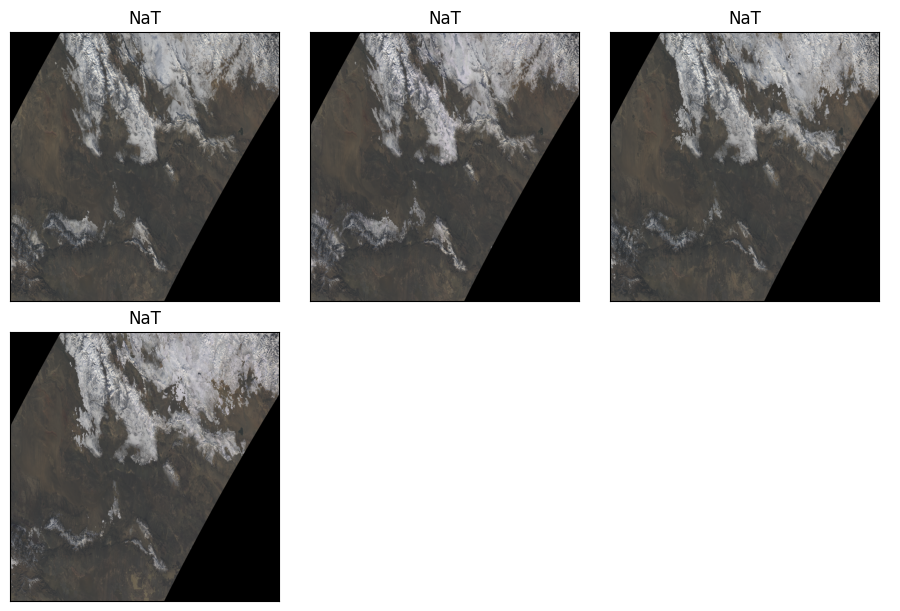

In [128]:
T = raster_source_viz.shape[0]
t_strs = [str(s.date()) for s in raster_source_viz.data_array.time.to_series()]

ncols = 3
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for t, t_str, ax in zip(range(T), t_strs, axs.flat):
    chip = raster_source_viz[t, 600:1800, 600:1800]
    ax.imshow(chip)
    ax.set_title(t_str, fontsize=12)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
for i in range(t + 1, len(axs.flat)):
    axs.flat[i].axis('off')
plt.show()

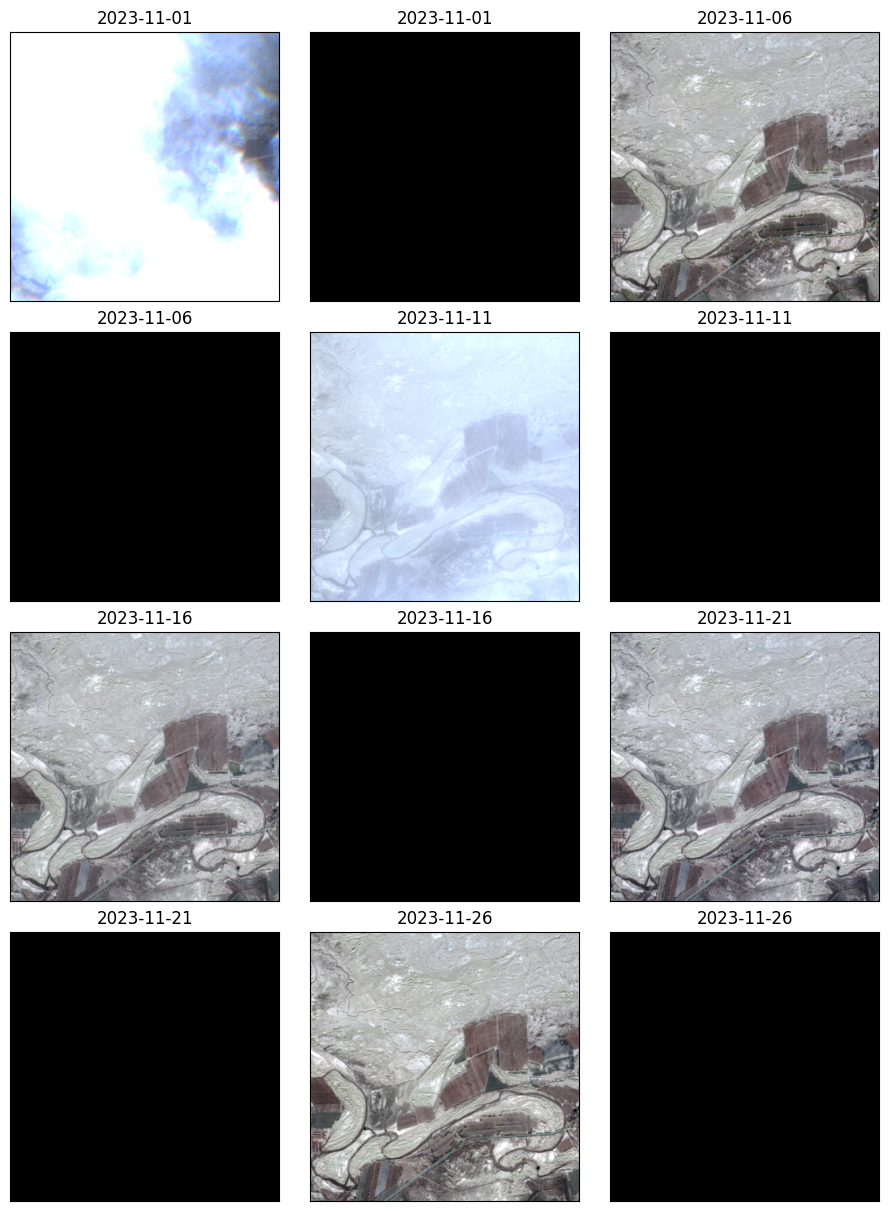

In [29]:
T = raster_source_viz.shape[0]
t_strs = [str(s.date()) for s in raster_source_viz.data_array.time.to_series()]

ncols = 3
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for t, t_str, ax in zip(range(T), t_strs, axs.flat):
    chip = raster_source_viz[t, :, :]
    ax.imshow(chip)
    ax.set_title(t_str, fontsize=12)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
for i in range(t + 1, len(axs.flat)):
    axs.flat[i].axis('off')
plt.show()